# 2: Structural Variations as Predictors of Functional Gene Disruption

In [3]:
import pandas as pd

# Load the dataset
dataset_path = 'consolidated_genome_data.csv'
data = pd.read_csv(dataset_path)

# Inspect the dataset
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73098 entries, 0 to 73097
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   assemblyAccession             53759 non-null  object 
 1   assemblyUnit                  53759 non-null  object 
 2   assignedMoleculeLocationType  53759 non-null  object 
 3   chrName                       53759 non-null  object 
 4   gcCount                       47464 non-null  float64
 5   gcPercent                     47464 non-null  float64
 6   genbankAccession              53759 non-null  object 
 7   length                        53759 non-null  float64
 8   refseqAccession               53759 non-null  object 
 9   role                          53759 non-null  object 
 10  sequenceName                  53759 non-null  object 
 11  ucscStyleName                 53759 non-null  object 
 12  unlocalizedCount              27084 non-null  float64
 13  S

In [27]:
# Check Available Columns and Handle Missing Data
print("Available Columns in Dataset:", data.columns)
# If 'GC_Content' exists, use it directly as gcPercent
if 'GC_Content' in data.columns:
    data['gcPercent'] = data['GC_Content']
    print("'gcPercent' set to 'GC_Content'")

# Handle missing data: Impute missing 'gcPercent' with median
data['gcPercent'] = data['gcPercent'].fillna(data['gcPercent'].median())
print("'gcPercent' missing values imputed.")

# Ensure 'gene_length' exists (already present)
if 'gene_length' not in data.columns and 'start' in data.columns and 'end' in data.columns:
    data['gene_length'] = data['end'] - data['start']
    print("'gene_length' column created using 'start' and 'end'")
elif 'gene_length' not in data.columns:
    print("Error: 'gene_length' could not be created because 'start' or 'end' is missing.")

# Calculate gc_density safely
if 'gcPercent' in data.columns and 'gene_length' in data.columns:
    data['gc_density'] = data['gcPercent'] / data['gene_length']
    print("'gc_density' calculated")
else:
    print("Cannot calculate 'gc_density' due to missing 'gcPercent' or 'gene_length'")

# Final cleanup: Drop rows with critical missing data
critical_columns = ['gcPercent', 'gene_length', 'chrName', 'start', 'end']
data = data.dropna(subset=[col for col in critical_columns if col in data.columns])

print(f"Dataset shape after handling missing data: {data.shape}")


Available Columns in Dataset: Index(['assemblyAccession', 'assemblyUnit', 'assignedMoleculeLocationType',
       'chrName', 'genbankAccession', 'length', 'refseqAccession', 'role',
       'sequenceName', 'ucscStyleName', 'Sequence_ID', 'Description',
       'GC_Content', 'Length_x', 'seqid', 'source', 'type', 'start', 'end',
       'score', 'strand', 'phase', 'attributes', 'Gene', 'Location',
       'Length_y', 'gene_length'],
      dtype='object')
'gcPercent' set to 'GC_Content'
'gcPercent' missing values imputed.
'gc_density' calculated
Dataset shape after handling missing data: (53574, 29)


In [29]:
# Calculate gene-specific features
data['gene_length'] = data['end'] - data['start']
data['gc_density'] = data['gcPercent'] / data['gene_length']

# Ensure no infinities or negatives
data = data.replace([float('inf'), -float('inf')], None).dropna()

# Log-transform `gc_density` for better scaling (if needed)
import numpy as np
data['log_gc_density'] = np.log1p(data['gc_density'])


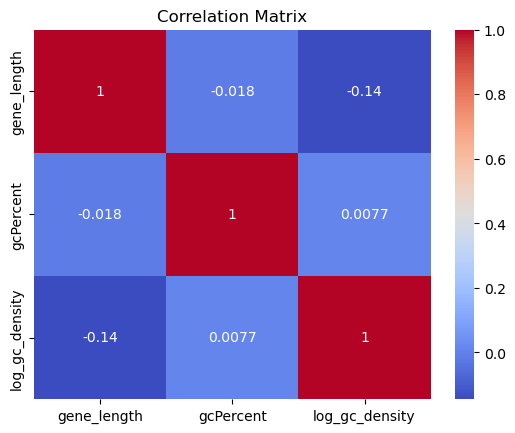

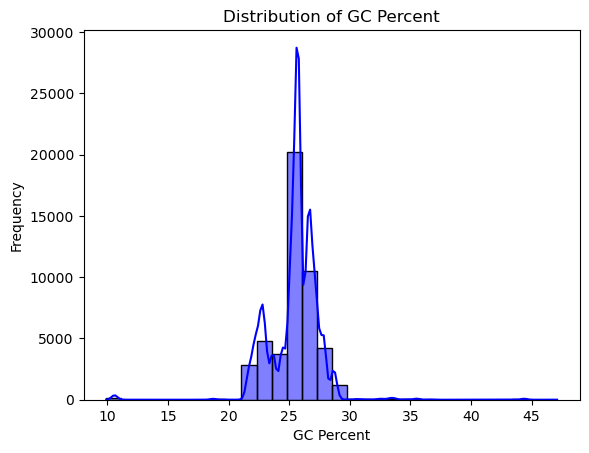

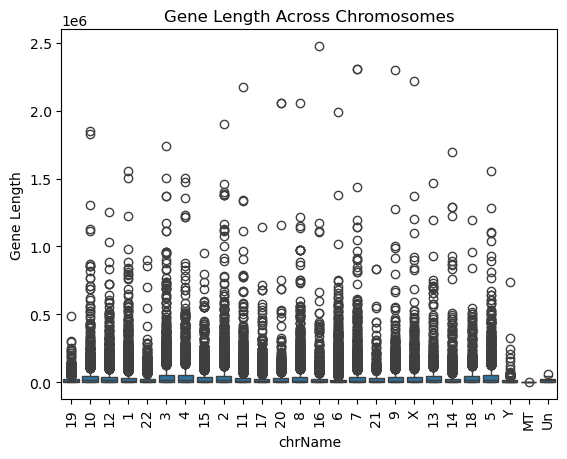

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation Heatmap
corr = data[['gene_length', 'gcPercent', 'log_gc_density']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Distribution of GC Percent
sns.histplot(data['gcPercent'], kde=True, bins=30, color='blue')
plt.title('Distribution of GC Percent')
plt.xlabel('GC Percent')
plt.ylabel('Frequency')
plt.show()

# Gene Length Boxplot
sns.boxplot(data=data, y='gene_length', x='chrName')
plt.title('Gene Length Across Chromosomes')
plt.xticks(rotation=90)
plt.ylabel('Gene Length')
plt.show()


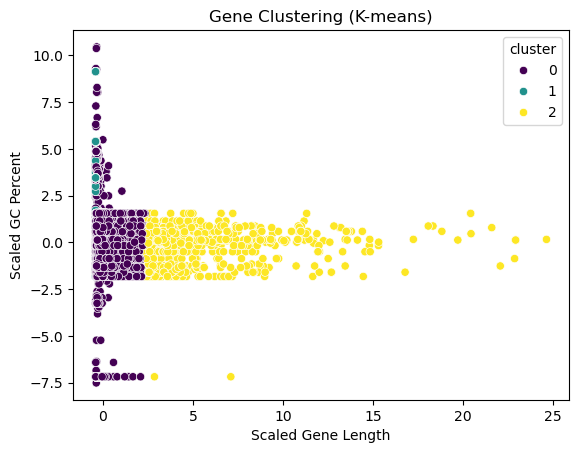

In [34]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = data[['gene_length', 'gcPercent', 'log_gc_density']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize clusters
sns.scatterplot(x=scaled_features[:, 0], y=scaled_features[:, 1], hue=data['cluster'], palette='viridis')
plt.title('Gene Clustering (K-means)')
plt.xlabel('Scaled Gene Length')
plt.ylabel('Scaled GC Percent')
plt.show()


In [35]:
# Cluster Summary
cluster_summary = data.groupby('cluster').agg({
    'gene_length': ['mean', 'std'],
    'gcPercent': ['mean', 'std'],
    'log_gc_density': ['mean', 'std']
})
print(cluster_summary)


           gene_length                 gcPercent           log_gc_density  \
                  mean            std       mean       std           mean   
cluster                                                                     
0         30906.392617   44561.849978  25.471642  2.055098       0.005513   
1            86.406682      24.993389  25.390614  2.299749       0.276201   
2        508681.763485  301941.821880  25.288600  1.676246       0.000060   

                   
              std  
cluster            
0        0.010928  
1        0.090356  
2        0.000022  


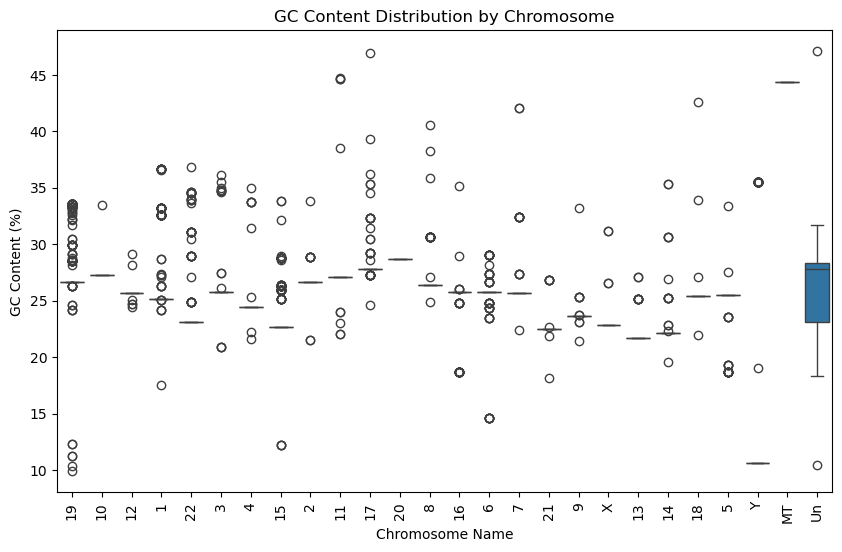

In [48]:
# Boxplot for GC Content by Chromosome
plt.figure(figsize=(10, 6))
sns.boxplot(x='chrName', y='gcPercent', data=data)
plt.title('GC Content Distribution by Chromosome')
plt.xlabel('Chromosome Name')
plt.ylabel('GC Content (%)')
plt.xticks(rotation=90)
plt.show()


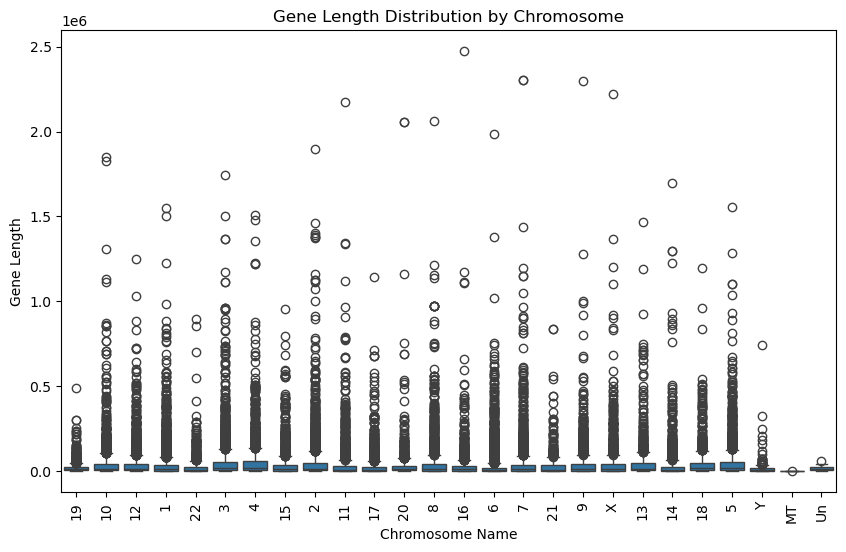

In [50]:
# Boxplot for Gene Length by Chromosome
plt.figure(figsize=(10, 6))
sns.boxplot(x='chrName', y='gene_length', data=data)
plt.title('Gene Length Distribution by Chromosome')
plt.xlabel('Chromosome Name')
plt.ylabel('Gene Length')
plt.xticks(rotation=90)
plt.show()


Index(['assemblyAccession', 'assemblyUnit', 'assignedMoleculeLocationType',
       'chrName', 'genbankAccession', 'length', 'refseqAccession', 'role',
       'sequenceName', 'ucscStyleName', 'Sequence_ID', 'Description',
       'GC_Content', 'Length_x', 'seqid', 'source', 'type', 'start', 'end',
       'score', 'strand', 'phase', 'attributes', 'Gene', 'Location',
       'Length_y', 'gene_length', 'gcPercent', 'gc_density', 'log_gc_density',
       'cluster'],
      dtype='object')


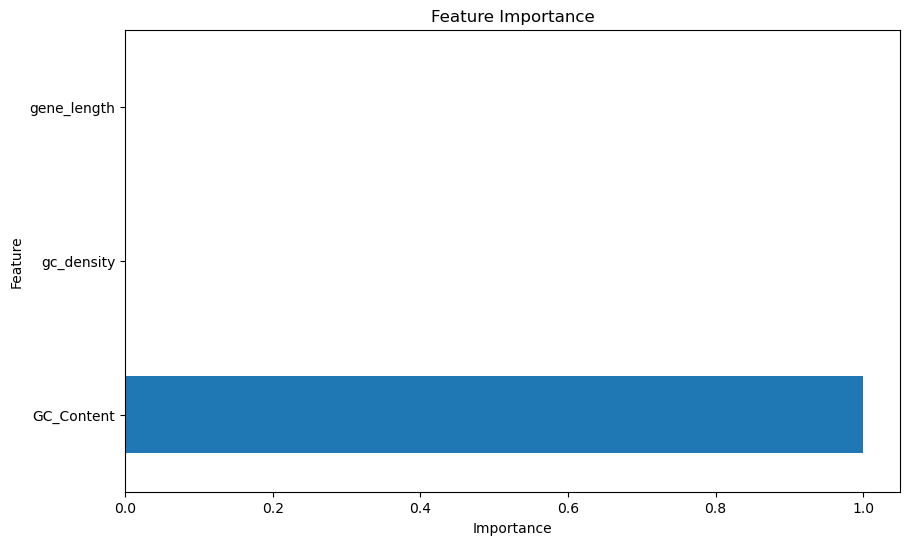

In [82]:
print(data_cleaned.columns)
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt

# Prepare the data - use the relevant columns for prediction
X = data_cleaned[['gene_length', 'gc_density', 'GC_Content']]  # Adjusted predictors
y = data_cleaned['gcPercent']  # Target variable

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, y)

# Get feature importance
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importance
feature_importance.plot(kind='barh', figsize=(10, 6))
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Optionally, you can use the trained model to make predictions and evaluate its performance.



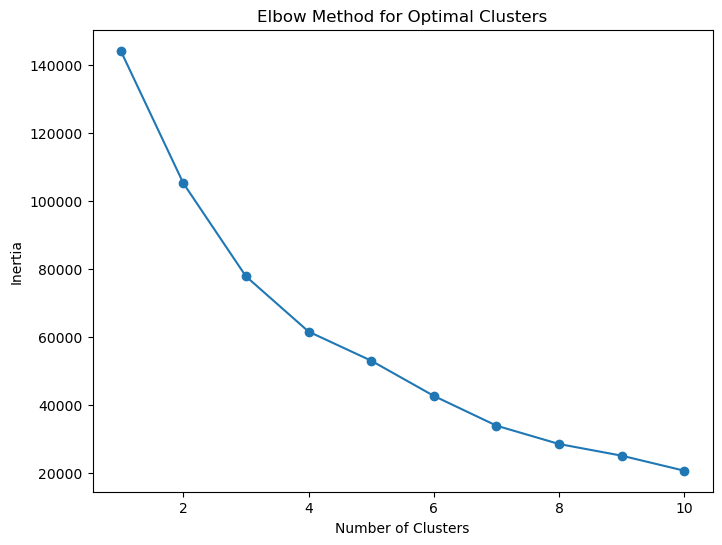

In [86]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_cleaned[['gcPercent', 'gene_length', 'gc_density']].dropna())

# Elbow plot to find optimal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()
